In [36]:
# Author: Muhammad Fathur Rizky
# Description: This notebook provides the implementation of Arima for time series forecasting

In [37]:
# !pip install pmdarima

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima import auto_arima
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer

import warnings 
warnings.filterwarnings('ignore')

In [39]:
df = pd.read_csv('data\daily-minimum-temperatures-in-me.csv')
df.rename(columns={'Daily minimum temperatures': 'temperature', 'Date': 'date'}, inplace=True)
df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')
df.dropna(subset=['temperature'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3647 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         3647 non-null   object 
 1   temperature  3647 non-null   float64
dtypes: float64(1), object(1)
memory usage: 85.5+ KB


In [40]:
def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    if isinstance(y_true, pd.Series):
        y_true = y_true.values
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.values
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_squared_error(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    if isinstance(y_true, pd.Series):
        y_true = y_true.values
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.values
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    return np.mean((y_true - y_pred) ** 2)

In [41]:
split = int(len(df) * 0.8)
df_train = df[:split]
df_test = df[split:]
df_train.shape, df_test.shape

((2917, 2), (730, 2))

In [42]:
def stationarity_checking(X: np.ndarray) -> pd.DataFrame:
    result = pd.DataFrame(columns=['t-stats', 'p-value', 'stationarity'])
    adf = adfuller(X)
    result.loc['ADF'] = [adf[0], adf[1], adf[1] <= 0.05]
    kolmogorov = adfuller(X, regression='ct')
    result.loc['Kolmogorov'] = [kolmogorov[0], kolmogorov[1], kolmogorov[1] <= 0.05]
    
    return result

def lag_features(df: pd.DataFrame, column: str, lags: list) -> pd.DataFrame:
    for t in lags:
        df[f'{column}_lag_{t}'] = df[column].shift(t)
    return df

def time_length_control(_df: pd.DataFrame, length: int) -> pd.DataFrame:
    df = _df.copy()
    df = df.iloc[-length:]
    display(df)
    return df

In [ ]:
class Solution {
 public:
  int dx[4] = {1, 0, 0, -1};
  int dy[4] = {0, 1, -1, 0};
  int islandSize[100001];
  int n, m;
  int mark = -1;

  int dfs(int i, int j, vector<vector<int>>& grid) {
    grid[i][j] = mark;
    int size = 1;

    for (int k = 0; k < 4; k++) {
      int ii = i + dx[k];
      int jj = j + dy[k];
      if (ii >= 0 && ii < n && jj >= 0 && jj < m && grid[ii][jj] == 1) {
        size += dfs(ii, jj, grid);
      }
    }
    return size;
  }

  int largestIsland(vector<vector<int>>& grid) {
    n = grid.size();
    m = grid[0].size();
    int ans = -1;
    int zero = 1;

    for (int i = 0; i < n; i++) {
      for (int j = 0; j < m; j++) {
        if (grid[i][j] == 1) {
          islandSize[abs(mark)] = dfs(i, j, grid);
          mark--;
        }
        zero &= grid[i][j];
      }
    }
    if (zero) return n * m;

    for (int i = 0; i < n; i++) {
      for (int j = 0; j < m; j++) {
        if (!grid[i][j]) {
          unordered_set<int> s;
          int newSize = 1;
          for (int k = 0; k < 4; k++) {
            int ii = i + dx[k];
            int jj = j + dy[k];
            if (ii >= 0 && ii < n && jj >= 0 && jj < m && grid[ii][jj] < 0) {
              if (!s.count(grid[ii][jj]))
                newSize += islandSize[abs(grid[ii][jj])];
              s.insert(grid[ii][jj]);
            }
          }
          ans = max(ans, newSize);
        }
      }
    }

    return ans;
  }
};


In [45]:
mape_list = []
mse_list = []

for i in range(1, 13):
    pipeline = Pipeline([
        # ('boxcox', BoxCoxEndogTransformer(lmbda2=1e-6)),  # lmbda2 avoids negative values
        ('arima', pm.AutoARIMA(start_p=0, start_q=0, 
                   max_p=3, max_q=3,
                   seasonal=False,
                   stepwise=True,
                   suppress_warnings=True))
    ])

    pipeline.fit(df_train['temperature'])   
    forecast = pipeline.predict(n_periods=len(df_test))
    
    # print error
    print(f"Seasonal: {i}")
    print(f"MAPE: {mape(df_test['temperature'], forecast)}")
    print(f"MSE: {mean_squared_error(df_test['temperature'], forecast)}")
    
    mape_list.append(mape(df_test['temperature'], forecast))
    mse_list.append(mean_squared_error(df_test['temperature'], forecast))

Seasonal: 1
MAPE: 45.52476675340504
MSE: 16.160733562372748
Seasonal: 2
MAPE: 45.52476675340504
MSE: 16.160733562372748
Seasonal: 3
MAPE: 45.52476675340504
MSE: 16.160733562372748
Seasonal: 4
MAPE: 45.52476675340504
MSE: 16.160733562372748
Seasonal: 5
MAPE: 45.52476675340504
MSE: 16.160733562372748
Seasonal: 6
MAPE: 45.52476675340504
MSE: 16.160733562372748


KeyboardInterrupt: 

In [20]:
# model = auto_arima(df_train['temperature'], seasonal=True, m=12, trace=True)

# forecast = model.predict(n_periods=len(df_test))



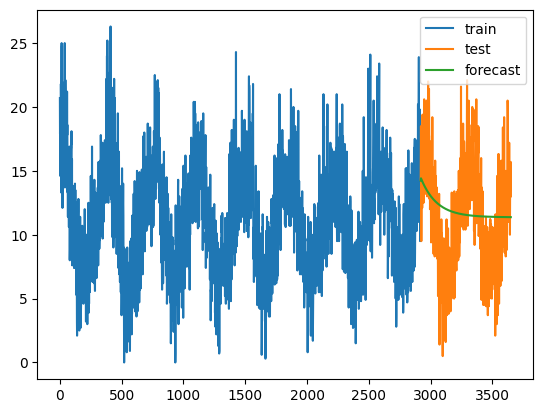

In [22]:
df_test['forecast'] = forecast
df_train['temperature'].plot()
df_test['temperature'].plot()
df_test['forecast'].plot()
plt.legend(['train', 'test', 'forecast'])
plt.show()

In [ ]:
# seasonal tuning dataframe
seasonal_tuning = pd.DataFrame({
    'seasonal': range(1, 13),
    'mape': mape_list,
    'mse': mse_list
})
display(seasonal_tuning)

In [23]:
scores = pd.DataFrame(columns=['MAPE', 'MSE'])
scores.loc['ARIMA'] = [mape(df_test['temperature'], df_test['forecast']), mean_squared_error(df_test['temperature'], df_test['forecast'])]
scores

,MAPE,MSE
ARIMA,44.865492,16.011889
